# Normalizing Flows Tutorial
#### David Ruhe

https://github.com/DavidRuhe/flows_tutorial

# How NFs Got Traction

#### Recap on VAEs

Let's start with VAEs. In VAEs we have the following Bayesian network:

$$Z \rightarrow X$$

Here, $X$ is a data-point, $Z$ is a latent representation of $X$.

If we examine the distributions over these random variables we can see that they are connected through Bayes' rule: 

$$p(Z \mid X) = \frac{p(Z)p(X \mid Z)}{p(X)}$$

Thus, we can model the data generating process by sampling from prior $Z$ and learning a model $p(X\mid Z)$ However, to learn $p(X \mid Z)$ we need $X, Z$ pairs. 

The most natural way to do so is by evaluating $p(Z \mid X)$, but this is intractable since $p(X)=\int p(X \mid Z)p(Z) dz$:

$$p(Z \mid X) = \frac{p(Z)p(X \mid Z)}{\int p(X \mid Z)p(Z) dz}$$

One alternative is by using Variational Bayes.


\begin{aligned}
\log{p(X)} &= \log{\int dz \, p(X, Z)} \\ &= \log \int dz \, p(X, Z)\frac{q(Z|X)}{q(Z|X)} \\ &= \log \mathbb{E}_{z \sim q(Z|X)}  \left[\frac{p(X, Z)}{q(Z|X)}\right] \\ &\geq \mathbb{E}_{z \sim q(Z|X)}  \left[ \log \frac{p(X, Z)}{q(Z|X)}\right] \\ &= \mathbb{E}_{z \sim q(Z|X)}  \left[ \log p(X|Z) + \log p(Z) - \log q(Z|X) \right] \\ &= \mathbb{E}_{z \sim q(Z|X)}  \left[ \log p(X|Z)  - \text{KL}[q(Z|X) \, || \, p(Z)]\right] \\ &:= -\mathcal{F}
\end{aligned}

The inequality originates from Jensens's inequality. Note that these are all terms we can evaluate.

Furthermore, let's look at the difference:


\begin{aligned}
\mathbb{E}_{z \sim q(z \mid X)}  \left[ \log \frac{p(X, Z)}{q(Z \mid X)}\right] -\log p(X) &= \mathbb{E}_{z \sim q(z \mid X)}  \left[ \log \frac{p(X, Z)}{q(Z \mid X)} - \log p(X) \right] \\ 
&= \mathbb{E}_{z \sim q(z \mid X)}  \left[ \log \frac{p(Z \mid X)}{q(Z \mid X)} \right] \\ 
&= \text{KL}[q(Z \mid X) \, || \, p(Z \mid X)]
\end{aligned}

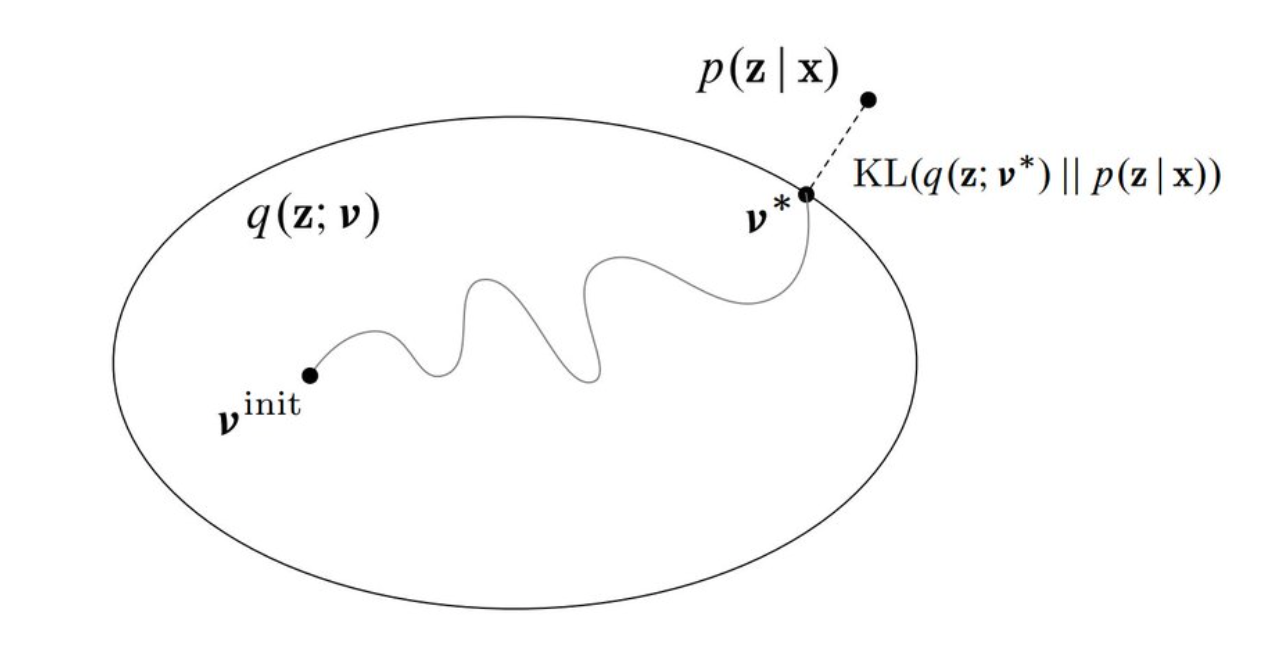

## Normalizing Flows

###### Change of Variables

As we see from the picture, if the variational distribution is not flexible enough, we can never reach the true posterior. This is the case for mean-field VI, where $q(Z \mid X) = \prod_{i=1}^K q(z_i \mid X)$. Thus, we need a way to parameterize a highly flexible family of distributions. By the change-of-variabes formula, we have

\begin{equation}
q(Z') = q(Z)\left \vert \, \det \frac{\partial f^{-1}}{\partial Z'} \right \vert = q(Z)\left \vert \, \det \left[\frac{\partial f}{\partial Z}\right]^{-1} \right \vert  = q(Z)\left \vert \, \det \frac{\partial f}{\partial Z} \right \vert^{-1}
\end{equation}

The 1D-case is shown as follows. Let $f$ be a monotonically increasing function and $Z'=f(Z)$, then

$$P(Z' \leq z') = P(f(Z)\leq z') = P(Z \leq f^{-1}(z')) = F_Z(f^{-1}(z'))$$

taking the derivative of the CDFs we get
$$p(Z') = p(Z) \cdot \frac{d}{dZ'} f^{-1}(Z')$$

For decreasing function the CDF is $1-F_Z(f^{-1})$, so the derivative has a negative sign. By taking the density and multiplying it with the absolute derivative we always get the correct value.

For an example on how the determinant shows up in the multi-variate case, see http://ksuweb.kennesaw.edu/~plaval//math2203/multint_jacobian.pdf .

This allows us to form an arbitrarily complex density by

$$Z_K = f_K \circ \dotsm \circ f_1(Z_0)$$

$$ \log q_K(Z_K) = \log q_0(Z_0) - \sum_{k=1}^K \log \, \left \lvert \, \det \frac{\partial f_k}{\partial Z_{k-1}} \right \rvert $$

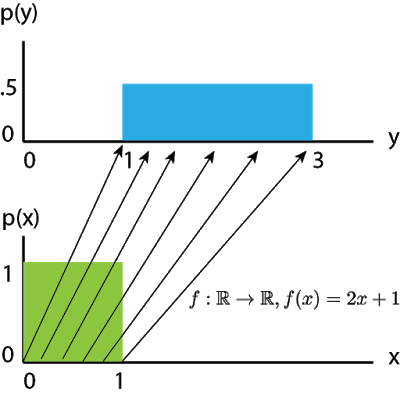

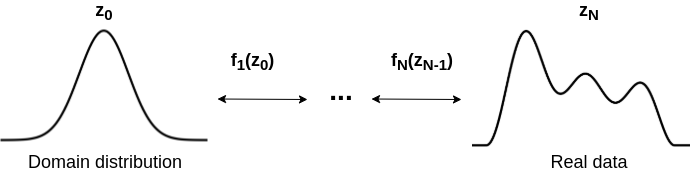

If we substitute the $q(Z)$ with $q_K(Z_K)$ in the ELBO derivation, we get a new ELBO:

\begin{aligned}
\log p(X) &\geq \mathbb{E}_{z \sim q_0(Z_0|X)} \left[ \frac{\log p(X, Z)}{q_K(Z_K)} \right] \\
&=\mathbb{E}_{z \sim q_0(Z_0|X)} \left[ \log \frac{ p(X, Z)}{q_K(Z_K)} \right] \\
&= \mathbb{E}_{z \sim q_0(Z_0|X)} \left[ \log p(X, Z) - \log q_0(Z_0|X) + \sum_{k=1}^K \log \, \left | \, \det \frac{\partial f_k}{\partial Z_{k-1}} \right | \right] \\
&:= -\mathcal{F}
\end{aligned}

### Invertibility Constraint (Rezende & Mohamed, 2015)

The original authors introduced a flow of the following form: 

$$f(\mathbf{z}) = \mathbf {z} + \mathbf{u} h(\mathbf {w}^T \mathbf {z} + b)$$

We then have $$\frac{\partial f}{\partial \mathbf z} = I + \mathbf u h'(\mathbf w ^T \mathbf z + b) \mathbf w^T$$
and through the [matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma)
$$\left| \, \det \, {\frac{\partial f}{\partial \mathbf z}}  \right| = \left | 1 + h'(\mathbf{w}^T \mathbf{z} + b) \mathbf w^T \mathbf{u} \right |$$

with $h'(\cdot) = 1 - h(\cdot)^2$ (as we use $\tanh$ as activation function).

Why is $f(\mathbf z)$ is invertible (with respect to $\mathbf z$)? Directly solving for $\mathbf z$ is not possible. We can split $\mathbf z$ into a perpendicular and parallel component: $\mathbf z = \mathbf z_\perp + \mathbf z_{||}$. 

<div>
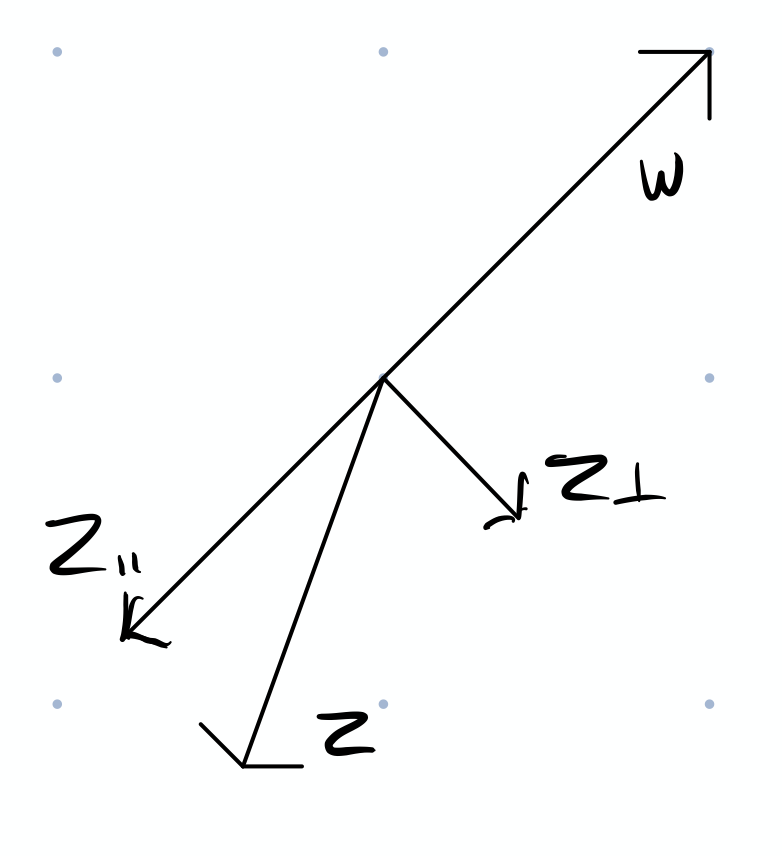
</div>

By doing so, and then writing $\mathbf z_{||}$ as a multiple of $\mathbf w$: $\mathbf z_{||} = \alpha \frac{\mathbf w}{\Vert \mathbf w \Vert^2}$ and multiplying both sides with $\mathbf w^T$ we get the following equation:


$$\mathbf w^T f(\mathbf z) = \alpha + \mathbf w^T \mathbf u h(\alpha + b)$$



Plotting this for $\mathbf w^T u = -1.2$ we see that the function is not invertible. Solving for $\mathbf w^T \mathbf u$ s.t. the derivative is $\geq 0 $ we get that it should be $\geq -1$.
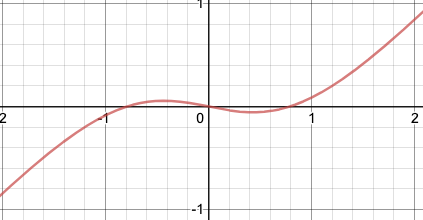

How do we obtain that? We can instead use a modified vector $$\hat{\mathbf u} = \mathbf u + [m(\mathbf w^T \mathbf u) - \mathbf w^T \mathbf u] \frac{\mathbf w}{\Vert \mathbf w \Vert^2}$$

where $m(\cdot)$ is the $-1 + \operatorname{softplus}(\cdot))$ function.

What this intuitively does is take $\mathbf u$ and shift it in the direction of $\mathbf w$ such that the dot product is larger than $-1$. The softplus function makes sure that when $\mathbf u$ already points in the direction of $\mathbf w$, we do not scale it (for stability).

<div>
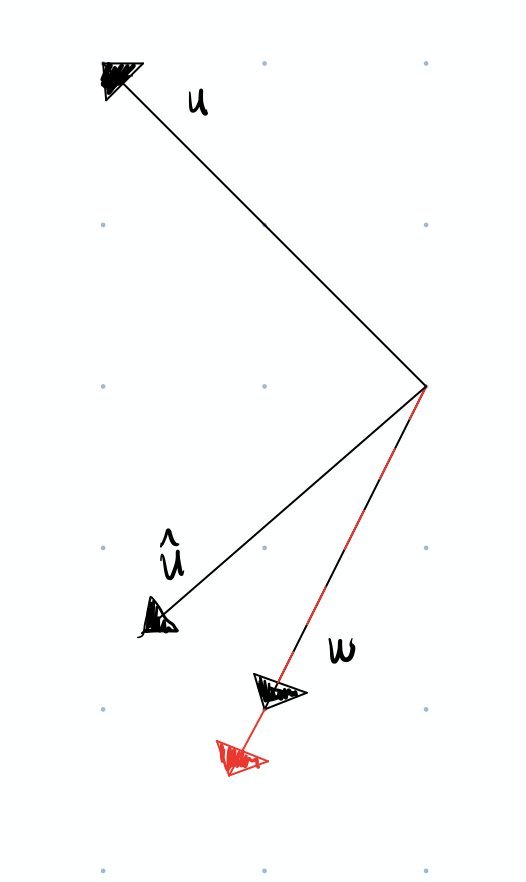
</div>

### Let's Implement!



$h'(\cdot) = 1 - h(\cdot)^2$.

In [ ]:
from torch import nn

class PlanarFlow(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.u = nn.Parameter(torch.rand(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.h = nn.Tanh()
        self.h_prime = lambda z: (1 - self.h(z) ** 2)

$$\hat{\mathbf u} = \mathbf u + [m(\mathbf w^T \mathbf u) - \mathbf w^T \mathbf u] \frac{\mathbf w}{\Vert \mathbf w \Vert^2}$$

In [ ]:
from torch import nn
import torch

class PlanarFlow(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.u = nn.Parameter(torch.rand(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.h = nn.Tanh()
        self.h_prime = lambda z: (1 - self.h(z) ** 2)

    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1 + torch.exp(x))
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))

$$f(\mathbf{z}) = \mathbf {z} + \mathbf{u} h(\mathbf {w}^T \mathbf {z} + b)$$

$$\left| \, \det \, {\frac{\partial f}{\partial \mathbf z}}  \right| = \left | 1 + h'(\mathbf{w}^T \mathbf{z} + b) \mathbf w^T \mathbf{u} \right |$$

In [ ]:
 from torch import nn

class PlanarFlow(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.u = nn.Parameter(torch.rand(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.h = nn.Tanh()
        self.h_prime = lambda z: (1 - self.h(z) ** 2)

    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1 + torch.exp(x))
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))
    
    def forward(self, z):
        u = self.constrained_u()
        hidden_units = torch.matmul(self.w.T, z.T) + self.b
        fz = z + u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)
        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)
        log_det = torch.log((1 + torch.matmul(u.T, psi)).abs() + 1e-15)
        return fz, log_det


$$ \log q_K(Z_K) = \log q_0(Z_0) - \sum_{k=1}^K \log \, \left \lvert \, \det \frac{\partial f_k}{\partial Z_{k-1}} \right \rvert $$


In [ ]:
class NormalizingFlow(nn.Module):

    def __init__(self, flow_length, dim):
        super().__init__()

        self.layers = nn.Sequential(
            *(PlanarFlow(dim) for _ in range(flow_length)))

    def forward(self, z):
        
        log_jacobians = 0

        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        return z, log_jacobians


flow = NormalizingFlow(4, 2)

Let's create an energy function that the flow can learn to match.

$$ f_1(\mathbf z) = \frac12 \left( \frac{\Vert \mathbf z \Vert - 2}{0.4} \right)^2 -  \ln\left( \exp \left[ -\frac 12 \left( \frac{z_1 - 2}{0.6} \right)^2 \right] + \exp \left[ -\frac12 \left( \frac{z_1 + 2}{0.6} \right)^2 \right] \right)$$


In [ ]:
def f1(z):
    return -((((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2) / 2 - torch.log(
    1e-15 + (torch.exp(-(((z[:, 0] - 2) / 0.6) ** 2) / 2) + torch.exp(-(((z[:, 0] + 2) / 0.6) ** 2) / 2))))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_exact_density(ax, exact_log_density, lims=np.array([[-4, 4], [-4, 4]]), nb_point_per_dimension=100,
                       cmap="coolwarm", title=None):
    xx, yy = np.meshgrid(np.linspace(lims[0][0], lims[0][1], nb_point_per_dimension),
                         np.linspace(lims[1][0], lims[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1))
    density = torch.exp(exact_log_density(z)).reshape(nb_point_per_dimension, nb_point_per_dimension)
    ax.imshow(density, extent=([lims[0][0], lims[0][1], lims[1][0], lims[1][1]]), cmap=cmap)
    if title is not None:
        plt.title(title, fontsize=22)
        
fig, ax = plt.subplots()
plt.xticks([], []); plt.yticks([], [])
plot_exact_density(ax, f1)

$$ \log q_K(Z_K) = \log q_0(Z_0) - \sum_{k=1}^K \log \, \left \lvert \, \det \frac{\partial f_k}{\partial Z_{k-1}} \right \rvert $$


In [ ]:
import math 
from tqdm import tqdm

def gaussian_log_pdf(z):
    return -.5 * (torch.log(torch.tensor([math.pi * 2], device=z.device)) + z ** 2).sum(1)

def train(flow, optimizer, epochs, log_density, batch_size, data_dim):
    training_loss = 0
    for epoch in tqdm(range(epochs)):
        # Generate new samples from the flow
        z0 = torch.randn(batch_size, data_dim).to(device)
        zk, sum_log_jacobian = flow(z0)

        # Evaluate the exact and approximated densities
        flow_log_density = gaussian_log_pdf(z0) - sum_log_jacobian
        
        exact_log_density = log_density(zk).to(device)

        # Compute the loss
        reverse_kl_divergence = (flow_log_density - exact_log_density).mean()
        optimizer.zero_grad()
        loss = reverse_kl_divergence
        loss.backward()
        optimizer.step()

        training_loss += loss.item()        
        
    return training_loss


In [ ]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
data_dim = 2
device = 'cuda'
flow = flow.to(device)
loss = train(flow, optimizer, 5000, f1, 128, data_dim)


In [ ]:
def plot_flow_density(flow, ax, lims=np.array([[-4, 4], [-4, 4]]), cmap="coolwarm", title=None,
                      nb_point_per_dimension=1000):
    # Sample broadly from the latent space
    latent_space_boundaries = np.array([[-15, 15], [-15, 15]]);
    xx, yy = np.meshgrid(
        np.linspace(latent_space_boundaries[0][0], latent_space_boundaries[0][1], nb_point_per_dimension),
        np.linspace(latent_space_boundaries[1][0], latent_space_boundaries[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1), dtype=torch.float)
    # Generate data points and evaluate their densities
    zk, sum_log_jacobian = flow(z.to(device))
#     sum_log_jacobian = sum(layer.ljd for layer in flow.layers).squeeze()
    
    final_log_prob = gaussian_log_pdf(z) - sum_log_jacobian.squeeze().cpu()
    qk = torch.exp(final_log_prob)
    
    ax.set_xlim(lims[0][0], lims[0][1]); ax.set_ylim(lims[1][0], lims[1][1])
    ax.pcolormesh(
        zk[:, 0].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension),
        zk[:, 1].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension) * -1,
        qk.detach().data.reshape(nb_point_per_dimension, nb_point_per_dimension),
        cmap=cmap,
        rasterized=True,
    )
    if title is not None:
        plt.title(title, fontsize=22)


In [ ]:
fig, ax = plt.subplots()
plot_flow_density(flow, ax,)


## Learning from data

#### RealNVP

In the previous, we tried to match $q(Z|X)$ to $p(Z|X)$ through maximizing a lower bound on the log-evidence. Through the usage of flows, we could form a more complex posterior and thus match the true posterior better. However, researchers realized that we could also just match the highly complex data distribution $p(X)$ directly, through generative models.

<!-- ![image.png](attachment:image.png) -->

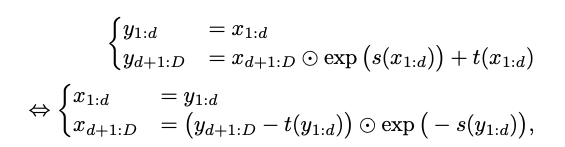

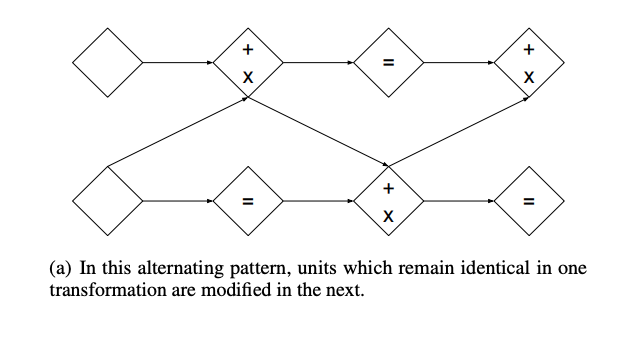

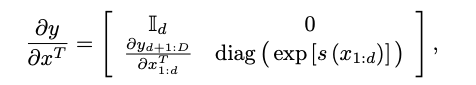

In [ ]:
class FCNN(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
class RealNVP(nn.Module):
    """
    Non-volume preserving flow.
    [Dinh et. al. 2017]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.t1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.t2 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s2 = base_network(dim // 2, dim // 2, hidden_dim)

    def forward(self, x):
        lower, upper = x[:,:self.dim // 2], x[:,self.dim // 2:]
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = t1_transformed + upper * torch.exp(s1_transformed)
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = t2_transformed + lower * torch.exp(s2_transformed)
        z = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(s1_transformed, dim=1) + \
                  torch.sum(s2_transformed, dim=1)
        return z, log_det

    def inverse(self, z):
        lower, upper = z[:,:self.dim // 2], z[:,self.dim // 2:]
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = (lower - t2_transformed) * torch.exp(-s2_transformed)
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = (upper - t1_transformed) * torch.exp(-s1_transformed)
        x = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(-s1_transformed, dim=1) + \
                  torch.sum(-s2_transformed, dim=1)
        return x, log_det


In [ ]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m, device=x.device)
        for flow in self.flows:
            x, ld = flow.forward(x)
            
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m, device=z.device)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

In [ ]:
import numpy as np
import torch

def gen_data(n=512):
    return np.r_[np.random.randn(n // 3, 2) + np.array([0, 6]),
                 np.random.randn(n // 3, 2) + np.array([2.5, 3]),
                 np.random.randn(n // 3, 2) + np.array([-2.5, 3])]

n = 512

x = torch.from_numpy(gen_data(n)).float().to(device)



In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
flows = 2
iterations = 500
flows = [RealNVP(dim=2, hidden_dim=8) for _ in range(flows)]
prior = MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
model = NormalizingFlowModel(prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [ ]:
for i in range(iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" +
                    f"Logprob: {logprob.mean().data:.2f}\t" +
                    f"Prior: {prior_logprob.mean().data:.2f}\t" +
                    f"LogDet: {log_det.mean().data:.2f}")


In [ ]:
def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], marker="x", **kwargs)
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))


x = x.cpu()
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 2)

plot_data(z.cpu().data, color="darkblue", alpha=0.5)
plt.title("Latent space")

plt.subplot(1, 3, 1)
plot_data(x.cpu(), color="black", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.title("Training data")

plt.subplot(1, 3, 3)
samples = model.sample(500).data.cpu()
plot_data(samples, color="black", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.title("Generated samples")
plt.show()


In [ ]:
plot_data(x.cpu(), color="black", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 10)

plt.show()

for f in flows:
    x = f(x.cuda())[0].data
    plot_data(x.cpu(), color="black", alpha=0.5)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.show()

### MNIST

In [ ]:
from torchvision.datasets import MNIST

iterations = 5000
flows = 8

flows = [RealNVP(dim=784, hidden_dim=64) for _ in range(flows)]
prior = MultivariateNormal(torch.zeros(784, device=device), torch.eye(784, device=device))
model = NormalizingFlowModel(prior, flows)

optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset = MNIST('./', download=True)
model = model.cuda()

x = dataset.data.to(device).reshape(-1, 784).float()[:256] / 256

for i in range(iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model(x + 1e-1 * torch.randn_like(x, device=x.device))
    logprob = prior_logprob + log_det 
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" +
                    f"Logprob: {logprob.mean().data:.2f}\t" +
                    f"Prior: {prior_logprob.mean().data:.2f}\t" +
                    f"LogDet: {log_det.mean().data:.2f}")



In [ ]:
with torch.no_grad():
    img = model.sample(1).cpu().reshape(28, 28)

plt.imshow(img.clamp(0, 1))